**TRamWAy** - <u>T</u>he <u>Ra</u>ndo<u>m</u> <u>W</u>alk <u>A</u>nal<u>y</u>zer - features tools for processing single-molecule localization microscopy data.

This notebook introduces the [RWAnalyzer](https://tramway.readthedocs.io/en/master/tramway.analyzer.html#tramway.analyzer.RWAnalyzer) object and its main functionalities, as of version *0.5*.

#### Table of contents
* [Parameter maps](#Parameter-maps)
* [SPT analysis and data structures](#SPT-analysis-and-data-structures)
* [Locations, trajectories and translocations](#Locations,-trajectories-and-translocations)
* [ROI definition](#ROI-definition)
* [Tessellation](#Tessellation), [time segmentation](#Time-segmentation) and [sampling](#Sampling)
* [Parameter estimation](#Parameter-estimation)
    * [DV inference](#DV-inference)
    * [Custom mappers](#Custom-mappers)
    * [Analyzing trajectories](#Analyzing-trajectories)
    * [Embarrassingly parallel mapper functions](#Embarrassingly-parallel-mapper-functions)

Let us first download the data required by this notebook:

In [1]:
from tutorial import *

download_RWAnalyzer_tour_data()

This notebook also requires some extra dependencies, including `scikit-learn` (required), `stopit` (optional) and those listed in the `roi` installation target for TRamWAy (only `polytope` is required):

In [2]:
import sys

!"{sys.executable}" -m pip install polytope cvxopt stopit scikit-learn

This notebook introduces (again) some basic concepts of the TRamWAy approach.

Some of the models inherited from InferenceMAP are used to estimate parameters of the dynamics of the fluorescent particles in the imaged biological sample. Such models focus on resolving the dynamics in space (and time), and are fed with individual displacements instead of entire trajectories.

Nevertheless, TRamWAy also features tools for extracting and quantifying trajectories, and two sections are dedicated to this topic.

Back to the mere TRamWAy approach that consists of resolving the dynamics in space, let us first have a look to example parameter maps.

# Parameter maps
A key product TRamWAy generates out of single particle tracking data is a collection of parameter maps that quantify the local dynamics of the observed molecules and their environment.

Let us load a data file and visualize one such map before we dive into the details of getting these parameters:

In [3]:
from tramway.analyzer import *

a              = RWAnalyzer()

In [4]:
a.spt_data.from_rwa_file('data-examples/demo1.rwa')

A *.rwa* file also stores the result of analyses on these data.

For example this file contains effective potential maps. Let us visualize them:

In [5]:
# retrieve parameter maps
sampling_label = 'gwr + 60s windowing'
sampling       = a.spt_data.get_sampling(sampling_label)
map_label      = 'dv d=50 v=2 (ns)'
maps           = sampling.get_child(map_label)

In [6]:
# reload the time segmentation used to generate the maps
a.time.from_sampling(sampling)

In [7]:
%%capture
# initialize the movie for a parameter map
import matplotlib.pyplot as plt

fig, ax        = plt.subplots(figsize=(8,7))

movie          = a.mapper.mpl.animate(fig, maps, feature='potential',
                    axes=ax, unit='std', overlay_locations=True)

In [8]:
# render the movie
from IPython.display import HTML

HTML(movie.to_jshtml())

# SPT analysis and data structures
Let us rewind and go step by step.

First, we initialized an [RWAnalyzer](https://tramway.readthedocs.io/en/master/tramway.analyzer.html#tramway.analyzer.RWAnalyzer) object.

In [9]:
from tramway.analyzer import *

a = RWAnalyzer()

This object (here `a`) contains an attribute for addressing the single particle tracking data.

We initialized this attribute with a method that mutates the parent attribute itself and, in our case,
loads a *.rwa* file:

In [10]:
a.spt_data.from_rwa_file('data-examples/demo1.rwa')

For coders who prefer explicit assignment, the following alternative syntax is allowed:

    a.spt_data = spt_data.from_rwa_file('data-examples/demo1.rwa')

A *.rwa* file stores SPT data, together with results of the analyses performed on these data.
The analysis results are organized in a tree:

In [11]:
from tutorial import *

print_analysis_tree(a.spt_data.analyses, annotations=True)
# `print(a.spt_data.analyses)` works similarly

<class 'pandas.core.frame.DataFrame'>                              		<- original SPT data
	'gwr + 60s windowing' <class 'tramway.tessellation.base.Partition'>	<- data sampling
		'dv d=50 v=2 (ns)' <class 'tramway.inference.base.Maps'>	<- parameter maps


Here the tree features a single path, with the original data available at the top node:

In [12]:
a.spt_data.dataframe # or, equivalently, `a.spt_data.analyses.data`

n        x       y       t      dx      dy    dt
0         3  41.0294  7.0758   20.48  0.0453  0.1043  0.04
1         4  41.0882  7.0933   30.16 -0.0659  0.0746  0.04
2         5  41.0113  7.0608   30.36  0.0855  0.0980  0.04
3         6  41.0608  7.1048   30.60  0.0104  0.1294  0.04
4         7  41.0816  7.0902   30.68 -0.0945  0.0432  0.04
...     ...      ...     ...     ...     ...     ...   ...
12092  1856  41.0789  6.6456  794.88 -0.0431  0.0354  0.04
12093  1856  41.0358  6.6810  794.92  0.0290 -0.0924  0.04
12094  1856  41.0648  6.5886  794.96 -0.0611  0.0485  0.04
12095  1856  41.0037  6.6371  795.00  0.0998 -0.0704  0.04
12096  1856  41.1035  6.5667  795.04 -0.0335  0.0785  0.04

[12097 rows x 7 columns]

The `x` and `y` columns represent space coordinates, `t` represents time, `n` is the trajectory index, and the other columns are displacement information that are not always present at this level.

The above analysis tree exhibits a single sampling of these data and a single set of parameter maps inferred from the so-sampled data. There could be multiple samplings of the initial trajectory data, and multiple sets of parameter maps for each sampling. A label helps identify each processing step.

In the RWAnalyzer object, in addition to the above dataframe, the `spt_data` attribute stores more information such as `frame_interval` and `localization_error`.
If this information was not automatically loaded from the file, we would set:

In [13]:
a.spt_data.frame_interval         = 0.04 # in seconds
a.spt_data.localization_precision = 0.02 # in micrometers

The second level in the tree represents the data segmentation:

In [14]:
sampling_label = 'gwr + 60s windowing'
sampling       = a.spt_data.get_sampling(sampling_label)

# `sampling.data` is `a.spt_data.analyses[sampling_label].data`

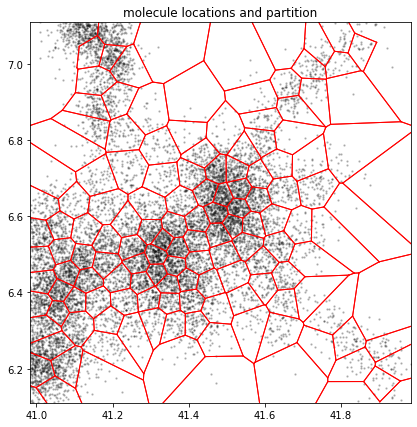

In [15]:
import matplotlib.pyplot as plt

fig, ax        = plt.subplots(figsize=(7,7))

ax.set_title('molecule locations and partition')

a.tesseller.mpl.plot(sampling, axes=ax)

The above plot shows the location data and the spatial segmentation.
In addition, the tessellation was combined with a time window, and the translocations were eventually assigned to the resulting spatio-temporal microdomains with extra constraints on the number of points per microdomain.

All this process is split in the *tessellation*, *time segmentation* and *sampling* of the data, and each step is controlled by a specific analyzer attribute.

The resulting data sampling found in the *demo1.rwa* file was obtained with the following parameters:

In [16]:
a.tesseller            = tessellers.GWR
a.tesseller.resolution = .1

a.time.from_sliding_window(duration=60, shift=30)

a.sampler.from_nearest_neighbors(20)

The third level of the analysis tree stores maps of dynamics parameters resolved in space and time:

In [17]:
# retrieve parameter maps
map_label = 'dv d=50 v=2 (ns)'
maps      = sampling.get_child(map_label)

# `maps.data` is `a.spt_data.analyses[sampling_label][map_label].data`

The above movie shows the time-varying diffusivity, which quantifies the random component in the local dynamics.

More inferred parameters are available in the `maps` object.
They are referred to as *features*, which names are explicitly listed in the object:

In [18]:
print(maps.data)

mode:                     stochastic.dv
diffusivity_prior:        50
potential_prior:          2
jeffreys_prior:           True
runtime:                  24088.606165647507
V0:                       0
allow_negative_potential: True
sigma:                    0.02
stochastic:               False
features:                 ['diffusivity', 'potential', 'force']
maps:                     <class 'pandas.core.frame.DataFrame'>


As an example, we can generate a movie for another feature, say the effective potential:

In [19]:
%%capture
# initialize the movie for a parameter map
import matplotlib.pyplot as plt

fig, ax   = plt.subplots(figsize=(8,7))

movie     = a.mapper.mpl.animate(fig, maps, feature='diffusivity',
                axes=ax, unit='std', overlay_locations=True, logscale=True)

In [20]:
# render the movie
from IPython.display import HTML

HTML(movie.to_jshtml())

These maps were obtained in a single inference with the following parameters:

In [21]:
a.mapper.from_plugin('stochastic.dv')
a.mapper.stochastic               = False # behaves like the 'dv' plugin, with more options
a.mapper.diffusivity_prior        = 50
a.mapper.potential_prior          = 2
a.mapper.jeffreys_prior           = True
a.mapper.worker_count             = 16    # number of simultaneously processed time segments
a.mapper.V0                       = 0     # flat initial potential
a.mapper.allow_negative_potential = True

... and code:

In [22]:
def sample_and_infer(self):
    """ `self` is the `RWAnalyzer` object """
    
    for f in self.spt_data: # for each SPT data file (this also works with a single file)
        
        # if not already loaded, the file is actually loaded at this point
        sptdata  = f.dataframe
        
        # keep only the molecules that move by more than the localization error
        sptdata  = f.discard_static_trajectories(sptdata)
        
        # apply the `tesseller.tessellate`, `time.segment` and `sampler.sample` steps all at once
        sampling = self.sampler.sample(sptdata)
        
        # parameter inference takes time...
        maps     = self.mapper.infer(sampling)
        
        # wrap the original `sampling` and `maps` objects in node-like objects;
        # this stores the analysis artefacts in the analysis tree for `f`
        sampling = commit_as_analysis(sampling_label, sampling, parent=f)
        maps     = commit_as_analysis(map_label, maps, parent=sampling)
        
        # save to file
        f.analyses.rwa_file = 'data-examples/demo1.rwa' # output file path
        f.analyses.save()
        

Here, `sampler.sample` calls the `tessellate` and `segment` methods of the `tesseller` and `time` attributes respectively. Of note, the `sampler` attribute would exhibit a working `sample` method even if not initialized.

At this point, `sample_and_infer` can run as-is:

```
sample_and_infer(a)
```

Actually, the code in the body of the function could run without making it a function,
but we do not want it to run now, as the `infer` step may take a few hours to complete.

As a function, the processing is also ready to be parallized using the pipeline capability of [RWAnalyzer](https://tramway.readthedocs.io/en/master/tramway.analyzer.html#tramway.analyzer.RWAnalyzer):

```
a.pipeline.append_stage(sample_and_infer, granularity='spt data')

a.env              = environments.LocalHost
a.env.worker_count = 20

try:
    a.env.script   = __file__
except NameError:
    # in an IPython notebook, __file__ is not defined
    a.env.script   = 'RWAnalyzer tour.ipynb'

a.run()
```

More backends (*environments*) are available, including job submission on a remote computer cluster, using SSH and Slurm.

Note that the inference defined above already fans out the different time segments onto different local cores and, combined with `granularity='spt data'`, the additional parallelization brought by the `LocalHost` environment would only be useful to process multiple files at the same time (but beware the total number of workers...)

The pipeline capability is demonstrated in [another notebook](RWAnalyzer%20standard%20pipeline.ipynb).

### Summary
Before any analysis is run and a *.rwa* file is generated, the SPT data often come as a text file.

To sum up, and as a transition to the next section, let us export the SPT data to an ascii file and start from scratch without printing or plotting anything:

In [23]:
a.spt_data.to_ascii_file('data-examples/demo1.txt')

In [24]:
from tramway.analyzer import *

a = RWAnalyzer()

Note the main difference:

In [25]:
a.spt_data.from_ascii_file('data-examples/demo1.txt')

In [26]:
a.spt_data.frame_interval         = 0.04 # in seconds
a.spt_data.localization_precision = 0.02 # in micrometers

a.tesseller                       = tessellers.GWR
a.tesseller.resolution            = .1

a.time.from_sliding_window(duration=60, shift=30)

a.sampler.from_nearest_neighbors(20)

a.mapper.from_plugin('stochastic.dv')
a.mapper.stochastic               = False # behaves like the 'dv' plugin, with more options
a.mapper.diffusivity_prior        = 50
a.mapper.potential_prior          = 2
a.mapper.jeffreys_prior           = True
a.mapper.worker_count             = 16    # number of simultaneously processed time segments
a.mapper.V0                       = 0     # flat initial potential
a.mapper.allow_negative_potential = True

... and we are ready!

In [27]:
# sample_and_infer(a)

Note that, if you want to adapt `sampling_label` and `map_label`, you will have to redefine `sample_and_infer`.

# Locations, trajectories and translocations
Location and displacement information is made available in `pandas.DataFrame`s. However, there are subtle differences between trajectories and translocations.

Let us load some localization data:

In [28]:
from tramway.core import load_xyt

locations = load_xyt('data-examples/c05_low_density.tsf.xyt', columns=list('xyt'))
locations

x        y      t
0      26.6615  39.5796   0.06
1      26.1820  43.4160   0.06
2      27.0411  26.9305   0.06
3      29.1381  48.5524   0.06
4      30.5583  21.6255   0.06
...        ...      ...    ...
33546  55.6979  43.6495  31.20
33547  55.8001  45.0347  31.20
33548  59.9244  36.4617  31.20
33549  58.5234  29.2296  31.20
33550  58.7866  36.8735  31.20

[33551 rows x 3 columns]

The `x` and `y` columns represent space, in $\mu m$, and `t` represents time, in $s$.

The frame interval appears to be 0.06 and, as can be seen above in the dataframe, the locations are ordered in time.

The `tramway.core` module exports convenience functions like `iter_frames` to loop over the locations grouped by frame.

## Localization data tracking
Let us track these data using the *non-tracking* tracker:

In [29]:
from tramway.analyzer import *

a                                    = RWAnalyzer()
a.tracker.from_non_tracking()
a.tracker.frame_interval             = 0.06

This algorithm requires some hint about the values expected for diffusivity, plus an indication about the localization precision or error:

In [30]:
a.tracker.estimated_high_diffusivity = 0.3
a.tracker.localization_precision     = 0.03

### Side note
Some key parameters such as `frame_interval` and `localization_precision` are available at multiple places.
These parameters are actually stored in the `spt_data` attribute:

In [31]:
a.spt_data.frame_interval

0.06

This has been made possible by the `tracker` attribute altering the `spt_data` attribute:

In [32]:
a.spt_data

... while it was beforehands:

In [33]:
RWAnalyzer().spt_data

## Tracking (continued)

In [34]:
a.tracker.track(locations, register=True)

n        x        y      t
0         1  26.1820  43.4160   0.06
1         1  26.2917  43.2076   0.12
2         2  27.0411  26.9305   0.06
3         2  27.3263  26.7477   0.12
4         3  22.3443  46.9515   0.06
...     ...      ...      ...    ...
12850  5097  59.7249  40.3669  31.20
12851  5098  47.0593  36.7691  31.14
12852  5098  47.3644  36.9945  31.20
12853  5099  36.9425  36.9245  31.14
12854  5099  36.7721  37.0181  31.20

[12855 rows x 4 columns]

The `track` method applied to the example localization file returned a `pandas.DataFrame` that represents the resulting trajectories.
Column `n` encodes the trajectory index.
Rows are locations, ordered first by trajectory index and second by time.

The `register=True` option made `track` append the series of trajectories to the `spt_data` attribute:

In [35]:
for f in a.spt_data:
    pass
f.dataframe

n        x        y      t
0         1  26.1820  43.4160   0.06
1         1  26.2917  43.2076   0.12
2         2  27.0411  26.9305   0.06
3         2  27.3263  26.7477   0.12
4         3  22.3443  46.9515   0.06
...     ...      ...      ...    ...
12850  5097  59.7249  40.3669  31.20
12851  5098  47.0593  36.7691  31.14
12852  5098  47.3644  36.9945  31.20
12853  5099  36.9425  36.9245  31.14
12854  5099  36.7721  37.0181  31.20

[12855 rows x 4 columns]

Note here that we had to loop over items in `a.spt_data`.
Indeed, the `track` method can be called multiple times, on different files, and consequently the `spt_data` attribute could contain multiple items.

Because these *data provider* attributes (others are `images` and `roi`) are always iterable and often contain a single item, the `tramway.analyzer` package exports some very simple convenience functions to get the first or unique item of such iterators:

In [36]:
trajectories = single(a.spt_data).dataframe
trajectories

n        x        y      t
0         1  26.1820  43.4160   0.06
1         1  26.2917  43.2076   0.12
2         2  27.0411  26.9305   0.06
3         2  27.3263  26.7477   0.12
4         3  22.3443  46.9515   0.06
...     ...      ...      ...    ...
12850  5097  59.7249  40.3669  31.20
12851  5098  47.0593  36.7691  31.14
12852  5098  47.3644  36.9945  31.20
12853  5099  36.9425  36.9245  31.14
12854  5099  36.7721  37.0181  31.20

[12855 rows x 4 columns]

We can now run the same type of analyses on the SPT data, as presented before.

## Representations for trajectories and translocations
The models underlying the main inference methods available in TRamWAy do not need entire trajectories, but only individual displacements, or translocations.

To make the notion of translocation visible, let us define a region of interest and crop the data within this ROI:

In [37]:
a.spt_data.bounds

n        x        y      t
min     1.0  19.8098  19.2550   0.06
max  5099.0  61.5214  58.6531  31.20

In [38]:
from tramway.core import crop

cropped_trajectories = crop(trajectories, [20.,20.,10.,10.], keep_nan=True)
cropped_trajectories

n        x        y      t      dx      dy    dt
0    3  27.0411  26.9305   0.06  0.2852 -0.1828  0.06
1    3  27.3263  26.7477   0.12     NaN     NaN   NaN
2    4  27.2278  26.7087   0.24  0.1957 -0.1466  0.06
3    4  27.4235  26.5621   0.30     NaN     NaN   NaN
4    5  25.1026  29.9191   1.32     NaN     NaN   NaN
..  ..      ...      ...    ...     ...     ...   ...
94  46  24.5733  25.5749  28.68     NaN     NaN   NaN
95  47  27.0603  28.2362  29.34 -0.0411  0.2687  0.06
96  47  27.0192  28.5049  29.40     NaN     NaN   NaN
97  48  22.5607  28.6995  30.12  0.0184  0.0718  0.06
98  48  22.5791  28.7713  30.18     NaN     NaN   NaN

[99 rows x 7 columns]

We took a (huge) 10x10$\mu m$ area and found a hundred locations in it (these data are indeed low density...)

*delta* columns were added: `dx`, `dy` and `dt`.
They encode the displacement from the location described in the same row.

The terminal location for each trajectory exhibits undefined *delta* values.
As such, the above data are still considered as trajectory data.

Translocations are the rows with defined displacement information:

In [39]:
translocations = crop(trajectories, [20.,20.,10.,10.])
translocations

n        x        y      t      dx      dy    dt
0    3  27.0411  26.9305   0.06  0.2852 -0.1828  0.06
1    4  27.2278  26.7087   0.24  0.1957 -0.1466  0.06
2    6  25.1349  23.8702   1.56  0.1845  0.0494  0.06
3    7  24.7621  27.4019   1.62 -0.1749  0.1544  0.06
4    8  23.1742  29.7438   1.92  0.1180  0.0517  0.06
5    9  28.7786  24.6987   1.92  0.2697 -0.0591  0.06
6   11  23.3951  26.1521   2.40 -0.0637  0.0210  0.06
7   12  24.3211  28.6779   2.94  0.1078 -0.0966  0.06
8   13  23.8051  25.8957   3.06 -0.0228 -0.0425  0.06
9   14  23.5812  26.1698   3.48  0.0822  0.0590  0.06
10  15  25.8738  25.7641   3.66  0.0967  0.0583  0.06
11  16  25.5192  28.2850   4.02  0.0732 -0.0069  0.06
12  16  25.5924  28.2781   4.08  0.1413 -0.1463  0.06
13  17  25.8584  29.7977   4.80  0.1558  0.0857  0.06
14  18  28.7501  24.9676   4.80 -0.0514 -0.1258  0.06
15  19  28.3569  24.3927   4.98  0.1267 -0.2175  0.06
16  20  23.0978  26.6031   5.16  0.0110  0.1074  0.06
17  20  23.1088  26.7105   5.22  0.0810  0.0123  0.06
18  21  28.7045  24.0288   5.22 -0.2425 -0.0903  0.06
19  21  28.4620  23.9385   5.28  0.1078  0.1141  0.06
20  22  22.2845  29.7189   6.90 -0.0262 -0.1684  0.06
21  23  23.0325  27.7425   7.68 -0.1857  0.1743  0.06
22  24  26.9606  29.8861   7.74 -0.3520 -0.1299  0.06
23  24  26.6086  29.7562   7.80 -0.1021 -0.2357  0.06
24  25  29.3890  22.1387   8.16  0.0584  0.0700  0.06
25  26  26.4867  25.3496   8.46 -0.0874 -0.0899  0.06
26  27  27.5846  24.0548   9.48 -0.3406  0.1331  0.06
27  28  28.7021  21.1412   9.72  0.2424 -0.0729  0.06
28  29  23.5506  26.5477  10.08  0.1035 -0.0533  0.06
29  30  27.3245  26.7311  10.44  0.1943 -0.2405  0.06
30  30  27.5188  26.4906  10.50 -0.0489 -0.0745  0.06
31  31  22.8085  29.1061  10.68  0.0706 -0.1762  0.06
32  32  22.7433  28.1974  13.32 -0.1612 -0.0171  0.06
33  33  23.1388  26.7523  13.32 -0.0638 -0.0939  0.06
34  34  23.2600  26.7885  13.56 -0.1208  0.1310  0.06
35  35  23.4722  26.7546  13.74  0.0238 -0.0054  0.06
36  36  23.0787  27.4579  13.92 -0.0417 -0.2430  0.06
37  36  23.0370  27.2149  13.98 -0.1170  0.1601  0.06
38  37  29.3023  20.5713  16.20 -0.1950  0.1399  0.06
39  38  23.1069  29.9647  16.74  0.0198 -0.3451  0.06
40  39  22.5807  29.9396  18.06  0.0585 -0.0822  0.06
41  39  22.6392  29.8574  18.12  0.3057 -0.1412  0.06
42  40  24.9568  28.7359  19.32 -0.0768  0.0919  0.06
43  41  23.9873  26.3748  19.62  0.1324 -0.1729  0.06
44  42  25.0780  29.0597  19.68  0.1884 -0.2461  0.06
45  43  23.3956  29.0623  20.04 -0.2612 -0.2665  0.06
46  45  23.6875  29.2673  23.10  0.0428 -0.0589  0.06
47  46  24.4823  25.4458  28.44  0.0508 -0.0558  0.06
48  46  24.5331  25.3900  28.50 -0.0202  0.1878  0.06
49  46  24.5129  25.5778  28.56 -0.0652 -0.0410  0.06
50  46  24.4477  25.5368  28.62  0.1256  0.0381  0.06
51  47  27.0603  28.2362  29.34 -0.0411  0.2687  0.06
52  48  22.5607  28.6995  30.12  0.0184  0.0718  0.06

Some methods, <i>e.g.</i> for plotting trajectories, explicitly require trajectory data, while other methods require translocations only.

The `tramway.core` package exports conversion functions such as `trajectories_to_translocations` and `translocations_to_trajectories`.
This package also exports the `iter_frames` and `iter_trajectories` functions to iterate such dataframes over groups of rows.

# ROI definition
The above cropping can be generalized to many regions of interest using the `roi` attribute.
Regions of interest can be defined in many ways, as square areas centered at <i>e.g.</i> density peaks, or bounding boxes on the coordinates, including time, etc.


In [40]:
from tramway.analyzer import *

a                                    = RWAnalyzer()
a.tracker.from_non_tracking()
a.tracker.frame_interval             = 0.06
a.tracker.estimated_high_diffusivity = 0.3
a.tracker.localization_precision     = 0.03

In [41]:
from tramway.core import load_xyt

for source in (
        'data-examples/Manip01-01-Beta400AA-01-15ms.rpt.xyt',
        'data-examples/Manip01-01-Beta400AA-02-15ms.rpt.xyt'):
    
    xyt         = load_xyt(source, columns=['x', 'y', 'frame index'])
    
    xyt['t']    = xyt['frame index'] * a.tracker.frame_interval
    
    a.tracker.track(xyt, source=source, register=True)

In [42]:
from tramway.analyzer.roi.utils import *

roi_size        = 1.

for f in a.spt_data:
    roi_centers = density_based_roi(f.dataframe, .01)
    f.roi.from_squares(roi_centers, roi_size)


As of version *0.5*, the encouraged way to store such ROI center or boundary information is additional text files similar to SPT ascii files, with similar filenames as well, using a suffix before the extension to differenciate between SPT and ROI files.

In [43]:
import numpy as np
import pandas as pd
import os

for f in a.spt_data:
    basename, _ = os.path.splitext(f.source)
    
    f.to_ascii_file(basename+'.txt')
    
    f.roi.to_ascii_file(basename+'-roi.txt')
    

Let us simply print the number of translocations per ROI:

In [44]:
from tramway.analyzer import *

a = RWAnalyzer()
a.spt_data.from_ascii_files('data-examples/Manip01-01-Beta400AA-*-15ms.rpt.txt')

a.roi.from_ascii_files(suffix='-roi') # '-roi' is the default suffix and can be omitted

for r in a.roi.as_support_regions():
    # get the translocations that originate from within the roi bounding box
    sptdata     = r.crop()
    # the `source` attribute points to the spt data source;
    # the `label` attribute is the default label for any sampling of the ROI data
    print(r.source, r.label, len(sptdata), sep='\t')

data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt	roi000	186
data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt	roi001	327
data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt	roi002	406
data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt	roi003	334
data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt	roi004	278
data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt	roi005	488
data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt	roi006	524
data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt	roi007	393
data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt	roi008	396
data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt	roi009	280
data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt	roi010	212
data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt	roi011	441
data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt	roi012	452
data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt	roi013	188
data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt	roi014	185
data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt	roi015	214
data-exa

## Strategies for overlapping ROI

Regions of interest may exhibit some overlap, which is to be expected when they are automatically identified.
In the case of overlapping ROI, it usually makes sense to group these regions before segmenting the data and inferring model parameters.

Initializer methods for the `roi` attribute feature an optional `group_overlapping_roi` argument that can be set to `True`.
This combines the input ROI into so-called *support regions* for data processing, while the original ROI, termed *individual roi*, operate as windows on the corresponding support region.

As a consequence, the `roi` attribute can be iterated in two ways.
One can loop over either the individual ROI or the support regions, with the `as_individual_roi` or `as_support_regions` methods respectively.
Choosing what to iterate is made a requirement, and the `roi` attribute itself cannot be iterated as is.

Even if no grouping is performed (default behavior), `as_support_regions` should be used instead of `as_individual_roi` for data processing.
This has an impact on some flavors of parallel processing, in dispatching tasks with ROI granularity.

# Tessellation

To resolve the dynamics in space, TRamWAy offers several approaches for segmenting the space. These segmentation approaches all consist of partitioning the space into cells. They offer a basis for sampling the data into microdomains that may overlap as explained in the [sampling](#Sampling) section.

One of the most basic spatial segmentation approaches draws hexagonal tiles:

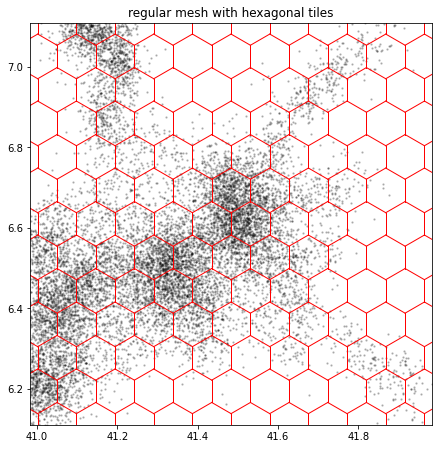

In [45]:
from tramway.analyzer import *
import matplotlib.pyplot as plt

a                                 = RWAnalyzer()

a.spt_data.from_ascii_file('data-examples/demo1.txt')
a.spt_data.localization_precision = 0.02
a.spt_data.frame_interval         = 0.04

a.tesseller                       = tessellers.Hexagons

as_                               = a.sampler.sample(a.spt_data.dataframe)

fig, ax                           = plt.subplots(1,1, figsize=(7.2,8))
a.tesseller.mpl.plot(as_, axes=ax, title='regular mesh with hexagonal tiles')

Another method, that adapts to the local density or local displacement length, is based on the Growing-When-Required self-organizing graph technique:

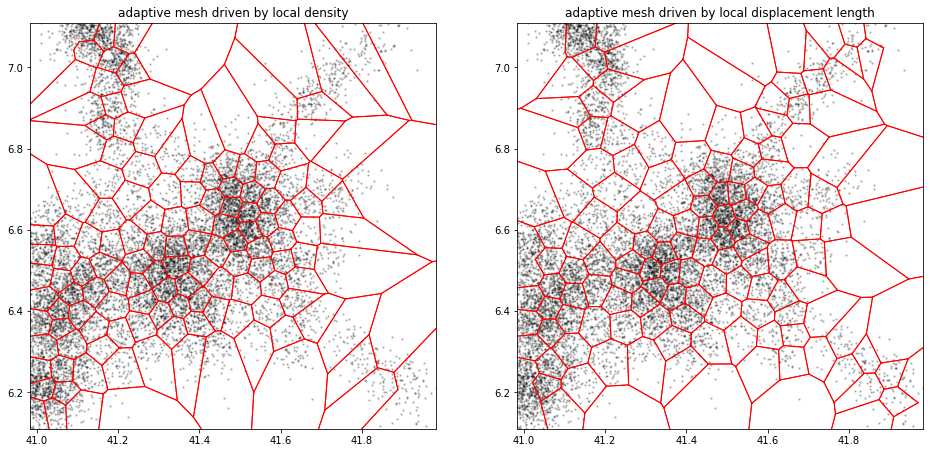

In [46]:
b                                 = RWAnalyzer()
b.tesseller                       = tessellers.GWR
b.tesseller.topology              = 'approximate density'
b.tesseller.resolution            = 0.1

c                                 = RWAnalyzer()
c.tesseller                       = tessellers.GWR
c.tesseller.topology              = 'displacement length'
c.tesseller.resolution            = 0.1


np.random.seed(23794837)
bs                                = b.sampler.sample(a.spt_data.dataframe)

np.random.seed(23794837)
cs                                = c.sampler.sample(a.spt_data.dataframe)
    
_, ax                             = plt.subplots(1,2, figsize=(16,8))
b.tesseller.mpl.plot(bs, axes=ax[0], title='adaptive mesh driven by local density')
c.tesseller.mpl.plot(cs, axes=ax[1], title='adaptive mesh driven by local displacement length')

Each tessellation approach offers specific parameters in addition to the general `resolution` parameter that is differently interpreted by the different approaches.

Most methods are referenced in the [documentation](https://tramway.readthedocs.io/en/latest/tessellation.html#standard-methods) and RWAnalyzer-adapted wrappers are featured by the `tessellers` module object for some of the available methods.

## Side effects

Note that we initialized multiple RWAnalyzer objects to process the data from only one analyzer object.

Generally this is not recommended.
The attributes that represent specific processing steps may access other attributes to gather all the necessary information.
As a consequence, side effects are to be expected.

![Class diagram](http://yuml.me/flaurent/rwanalyzer-and-representation-attributes.png)

Almost all the attributes access general parameters such as `frame_interval` and `localization_error` that are stored in the `spt_data` attribute.

Other dependencies exist in the `sampler` attribute that accesses the `tesseller` and `time` attributes, and in the `mapper` attribute that also accesses the `time` attribute.

## More about side effects

To prevent reusing analyzer objects, which may cause side effects, assigning a new value to an initialized attribute is not allowed:

In [47]:
%%script python3 --no-raise-error

from tramway.analyzer import *

a              = RWAnalyzer()
a.spt_data     = spt_data.from_ascii_file('data-examples/demo1.txt')

df             = a.spt_data.dataframe

# not allowed!
a.spt_data     = spt_data.from_dataframe(df)

Traceback (most recent call last):
  File "<stdin>", line 10, in <module>
  File "/home/flaurent/github/TRamWAy/tramway/analyzer/__init__.py", line 484, in __setattr__
    warnings.warn(


To allow attribute overwrite, and show an example side effect:

In [48]:
import warnings
warnings.simplefilter('ignore', SideEffectWarning)

a                                 = RWAnalyzer()

a.spt_data                        = spt_data.from_ascii_file('data-examples/demo1.txt')
a.spt_data.localization_precision = 0.03

a.time.frame_interval             = 0.05  # this actually sets `frame_interval` in `spt_data`

former_spt_data                   = a.spt_data

a.spt_data                        = spt_data.from_dataframe(former_spt_data.dataframe)
a.spt_data.localization_error     = former_spt_data.localization_error
a.spt_data.dt                     = former_spt_data.dt # `dt` is an alias for `frame_interval`

dict(
    localization_precision        = a.spt_data.localization_precision,
    frame_interval                = a.spt_data.frame_interval        )

{'localization_precision': 0.03, 'frame_interval': 0.05}

Some overwritting use cases are allowed through specific methods such as [reload_from_rwa_files](https://tramway.readthedocs.io/en/master/tramway.analyzer.html#tramway.analyzer.spt_data.SPTDataIterator.reload_from_rwa_files) that can be called when SPT data are processed from ascii files on a remote host, and retrieved as *.rwa* files onto the local host, to reload the resulting analysis trees from these *.rwa* files corresponding to the input ascii files.

## Other methods

Some tessellation methods such as InferenceMAP's quadtree, called *kdtree* in TRamWAy, are not available as dedicated wrappers.
They can be loaded as plugins:

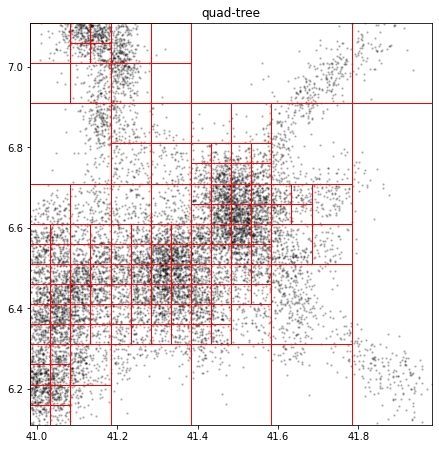

In [49]:
d                                 = RWAnalyzer()

d.tesseller.from_plugin('kdtree')
d.tesseller.resolution            = 0.05

ds                                = d.sampler.sample(a.spt_data.dataframe)

_, ax                             = plt.subplots(1,1, figsize=(7.2,8))
d.tesseller.mpl.plot(ds, axes=ax, title='quad-tree')

# Time segmentation

In addition to tessellating the space, the data can also be segmented into time segments, often using a sliding window:

In [50]:
from tramway.analyzer import *
import matplotlib.pyplot as plt

a                                 = RWAnalyzer()

a.spt_data.from_ascii_file('data-examples/demo1.txt')
a.spt_data.localization_precision = 0.02
a.spt_data.frame_interval         = 0.04

a.tesseller                       = tessellers.Hexagons

In [51]:
a.time.from_sliding_window(60)          # window duration in seconds
a.time.window_shift               = 45  # in seconds; this introduces a 25%-overlap between successive segments (default is no overlap)

In [52]:
sampling                          = a.sampler.sample(a.spt_data.dataframe)

One can iterate over the resulting time segments, as the following example that prints the number of translocations assigned to each segment:

In [53]:
for times, individual_segment_sampling in a.time.as_time_segments(sampling, return_times=True):
    print(
        a.time.segment_label(None, times, sampling),
        len(individual_segment_sampling.points),
        sep=': \t',
    )

t=20.48-80.48s: 	186
t=65.48-125.48s: 	730
t=110.48-170.48s: 	1048
t=155.48-215.48s: 	1339
t=200.48-260.48s: 	1365
t=245.48-305.48s: 	1142
t=290.48-350.48s: 	933
t=335.48-395.48s: 	981
t=380.48-440.48s: 	750
t=425.48-485.48s: 	526
t=470.48-530.48s: 	826
t=515.48-575.48s: 	1250
t=560.48-620.48s: 	1119
t=605.48-665.48s: 	1100
t=650.48-710.48s: 	964
t=695.48-755.48s: 	975
t=740.48-800.48s: 	925


A movie can be generated to visualize these points:

In [54]:
%%capture
fig, _                            = plt.subplots(figsize=(7,7))
movie                             = a.tesseller.mpl.animate(fig, sampling)

In [55]:
from IPython.display import HTML

HTML(movie.to_jshtml())

# Sampling

More importantly, these spatial and temporal segmentations are used to sample the (trans-)location data.
The default approach -- e.g. for space -- consists of partitioning, i.e. assigning to each microdomain all the points that lie within the corresponding Voronoi cell.
The Voronoi cells are illustrated as meshes in red in previous figures and movies.

However, the segmentations actually define the microdomains as center points only. The extent of the microdomains may be overriden so that a given point can be assigned to multiple microdomains, or none.

Data sampling is controlled by the `sampler` attribute.
It features several initializers, including [from_voronoi](https://tramway.readthedocs.io/en/latest/tramway.analyzer.html#tramway.analyzer.sampler.SamplerInitializer.from_voronoi) (default behavior), [from_spheres](https://tramway.readthedocs.io/en/latest/tramway.analyzer.html#tramway.analyzer.sampler.SamplerInitializer.from_spheres) and [from_nearest_neighbors](https://tramway.readthedocs.io/en/latest/tramway.analyzer.html#tramway.analyzer.sampler.SamplerInitializer.from_nearest_neighbors) that implement different behaviors along the spatial dimensions, and [from_nearest_time_neighbors](https://tramway.readthedocs.io/en/latest/tramway.analyzer.html#tramway.analyzer.sampler.SamplerInitializer.from_nearest_time_neighbors) for adapting the time window locally.

All the samplers first operate like `from_voronoi` and then perform local adjustments so as to enforce criteria such as a lower bound on the number of assigned points per microdomain.

Using alternative samplers, it is actually possible to assign data to microdomains that originally (following the default/initial behavior) do not contain any point.
This can also be controlled with an attribute common to all the samplers: [min_location_count](https://tramway.readthedocs.io/en/latest/tramway.analyzer.html#tramway.analyzer.sampler.BaseSampler.min_location_count).
In the former API (the `tessellate` function), this parameter is 1 per default, while it is 0 here.

The resulting segmentations are better illustrated with a color map and, as a consequence, an example sampling is explained in further details in the next section.

# Parameter estimation

Once microdomains are defined, with their respective (trans-)location data, all sorts of estimates can be extracted in each microdomain, taken individually or altogether, using the `mapper` attribute of an `RWAnalyzer` object.

TRamWAy features several [inference procedures](https://tramway.readthedocs.io/en/latest/inference.html#concepts) for models borrowed from InferenceMAP.

## DV inference

As showed in previous sections, the [DV model](https://tramway.readthedocs.io/en/latest/inference.html#inference-dv) explains the observed displacements as resulting from a diffusive term and a drift component derived from a potential lanscape:

$\frac{d\textbf{r}}{dt} = \sqrt{2D(\textbf{r})} \xi(t) - \frac{D(\textbf{r}) \nabla V(\textbf{r})}{k_\textrm{B} \textrm{T}}$

This model jointly estimates the local diffusivities $D$ (in $\mu m^2. s^{-1}$ if coordinates $\textbf{r}$ are expressed in $\mu m$) and effective potentials $V$ (actually expressed in $k_\textrm{B} \textrm{T}$ to ignore the corresponding factor in the above equation), and can be defined and applied in different ways:

* the *'dv'* plugin, suitable for moderate numbers of microdomains and, if a sliding window is applied to segment the data, as long as no time regularization is performed
* the *'stochastic.dv'* plugin, suitable for large inferences (many microdomains) and time-regularized inferences

The latter variant can be interrupted and/or a timeout can be defined, which makes it a better candidate for a rapid demonstration. Let us go straight to the figures, and then explain.

### Define the processing steps

In [56]:
from tramway.analyzer import *
import matplotlib.pyplot as plt

a                                 = RWAnalyzer()

a.spt_data.from_ascii_file('data-examples/demo1.txt')
a.spt_data.localization_precision = 0.02

a.tesseller                       = tessellers.Hexagons

a.sampler.from_nearest_neighbors(10)
a.sampler.min_location_count      = 1

In [57]:
a.mapper.from_plugin('stochastic.dv')
a.mapper.diffusivity_prior        = 20
a.mapper.potential_prior          = 1
a.mapper.max_runtime              = 20 # in seconds; note that if TRamWAy does not find the stopit package, this argument is ignored and the inference takes about 10 minutes
#a.mapper.verbose                  = False

### Process

In [58]:
# step 1. read the data
translocation_data                = a.spt_data.dataframe
# step 2. sample the data
data_sampling                     = a.sampler.sample(translocation_data)
# step 3. estimate the model parameters
inferred_parameters               = a.mapper.infer(data_sampling)

number of workers: 39
At iterate  10	f(107)= -1.355483E+02 	df= -6.570866E-01 	proj g = 1.161548E+00
At iterate  16	f(16)= -2.204677E+03 	df= -6.932966E+00 	proj g = 9.514301E+00
At iterate  27	f(11)= -2.380497E+02 	df= -3.077709E-01 	proj g = 2.981002E-01
At iterate  12	f(4)= -2.175916E+02 	df= -3.824575E-01 	proj g = 7.706706E-01
At iterate  31	f(98)= -5.566747E+02 	df= -2.842083E-01 	proj g = 5.954244E-01
At iterate  18	f(103)= -2.822216E+02 	df= -1.573773E-01 	proj g = 2.427105E-01
At iterate  24	f(112)= -3.974100E+02 	df= -5.291273E-01 	proj g = 9.480050E-01
At iterate  28	f(26)= -5.208585E+02 	df= -9.905701E-01 	proj g = 2.087079E+00
At iterate  14	f(94)= -2.971684E+02 	df= -5.321967E-01 	proj g = 1.533494E-01
At iterate   1	f(88)= -9.695650E+02 	df= -3.999182E-01 	proj g = 1.034154E+00
At iterate  11	f(8)= -8.579499E+02 	df= -8.326159E-01 	proj g = 1.108142E+00
At iterate  21	f(102)= -1.209763E+03 	df= -1.459449E+00 	proj g = 6.992921E-01
At iterate  25	f(27)= -3.311571E+03 	df=

At iterate 102	f( 7)= -2.303943E+03 	df= -8.334277E+00 	proj g = 1.543910E+01
At iterate 113	f(12)= -2.082551E+02 	df= -3.541271E-01 	proj g = 4.357909E-01
At iterate  87	f(40)= -5.359070E+03 	df= -3.124582E+00 	proj g = 4.500774E+00
At iterate 110	f(64)= -3.721163E+02 	df= -1.162928E-01 	proj g = 1.332215E-01
At iterate 112	f(100)= -2.363503E+03 	df= -7.038820E+00 	proj g = 1.502376E+01
At iterate  97	f(56)= -1.857756E+03 	df= -5.782292E+00 	proj g = 7.083887E+00
At iterate 108	f(96)= -8.689793E+02 	df= -2.761037E+00 	proj g = 6.189672E+00
At iterate  91	f(67)= -9.884481E+02 	df= -4.447102E-01 	proj g = 5.240402E-01
At iterate 118	f(17)= -3.660192E+03 	df= -3.087088E+01 	proj g = 7.532518E+01
At iterate 111	f(35)= -5.830258E+02 	df= -1.727771E+00 	proj g = 2.921329E+00
At iterate 123	f(102)= -1.227280E+03 	df= -3.342717E+00 	proj g = 1.378710E+01
At iterate 104	f(24)= -6.837974E+02 	df= -2.452445E-01 	proj g = 4.703944E-01
At iterate 109	f( 80)= -3.443198E+03 	df= -4.782185E+00 	proj 

At iterate 212	f(63)= -1.304979E+03 	df= -4.598005E-01 	proj g = 2.221311E+00
At iterate 199	f(44)= -2.042151E+03 	df= -1.292640E-02 	proj g = 1.806554E-02
At iterate 211	f(52)= -4.485314E+03 	df= -1.150047E-02 	proj g = 2.311316E-02
At iterate 206	f(47)= -4.176498E+03 	df= -4.403610E-02 	proj g = 8.311933E-02
At iterate 217	f( 88)= -9.876022E+02 	df= -1.097014E-01 	proj g = 2.195981E-01
At iterate 231	f(102)= -1.245261E+03 	df= -5.626612E-01 	proj g = 1.452919E+00
At iterate 215	f(70)= -6.151519E+03 	df= -6.231605E-01 	proj g = 1.246058E+00
At iterate 225	f( 91)= -7.358422E+02 	df= -2.736077E+00 	proj g = 6.241477E+00
At iterate 213	f(71)= -5.258559E+03 	df= -3.791864E+00 	proj g = 1.066854E+01
At iterate 210	f( 48)= -4.507080E+03 	df= -3.241197E-01 	proj g = 5.885904E-01
At iterate 219	f(56)= -1.885572E+03 	df= -3.901870E-02 	proj g = 1.190667E-01
At iterate 222	f(58)= -3.027696E+03 	df= -8.190392E-01 	proj g = 1.051513E+00
At iterate 208	f( 28)= -4.543416E+03 	df= -4.197736E-01 	pro

At iterate 324	f( 6)= -2.217604E+03 	df= -7.865591E-01 	proj g = 1.599835E+00
At iterate 330	f( 74)= -2.404985E+02 	df= -3.161523E-05 	proj g = 6.318662E-05
At iterate 313	f( 30)= -3.319263E+03 	df= -1.307957E-01 	proj g = 5.675065E-01
At iterate 326	f(55)= -1.042698E+03 	df= -2.553969E+00 	proj g = 4.547755E+00
At iterate 317	f(  7)= -2.420923E+03 	df= -4.834423E-01 	proj g = 2.113103E+00
At iterate 320	f( 90)= -9.675639E+02 	df= -3.324259E-03 	proj g = 7.644530E-03
At iterate 318	f( 18)= -2.496091E+03 	df= -8.020904E-01 	proj g = 1.744090E+00
At iterate 337	f( 15)= -3.345330E+02 	df= -1.080189E-02 	proj g = 3.809584E-02
At iterate 331	f(112)= -4.035383E+02 	df= -5.071037E-04 	proj g = 1.070682E-03
At iterate 333	f(26)= -5.281809E+02 	df= -3.267805E-03 	proj g = 7.700918E-03
At iterate 338	f( 4)= -2.210389E+02 	df= -1.310292E-03 	proj g = 3.016311E-03
At iterate 340	f( 98)= -5.667907E+02 	df= -2.323605E-03 	proj g = 1.083191E-02
At iterate 319	f(78)= -1.085640E+03 	df= -2.619948E-03 	

At iterate 415	f( 93)= -1.838970E+03 	df= -5.918111E-04 	proj g = 1.762425E-03
At iterate 430	f( 55)= -1.037439E+03 	df= -1.960441E-02 	proj g = 2.380063E-02
At iterate 435	f(103)= -2.863835E+02 	df= -1.476974E-02 	proj g = 2.897180E-02
At iterate 420	f( 51)= -6.284514E+03 	df= -1.234940E-01 	proj g = 6.369956E-01
At iterate 417	f( 69)= -3.979382E+03 	df= -7.051011E-01 	proj g = 1.410389E+00
At iterate 409	f( 73)= -6.727417E+02 	df= -1.090649E-02 	proj g = 1.403343E-02
At iterate 451	f(113)= -1.873905E+02 	df= -1.982014E-02 	proj g = 3.964000E-02
At iterate 425	f(53)= -1.887749E+03 	df= -4.300506E-01 	proj g = 8.599040E-01
At iterate 432	f(102)= -1.252496E+03 	df= -2.215749E+00 	proj g = 3.127581E+00
At iterate 414	f(78)= -1.086027E+03 	df= -1.736538E-01 	proj g = 5.562658E-01
At iterate 431	f( 90)= -9.691122E+02 	df= -5.614924E-01 	proj g = 1.123511E+00
At iterate 454	f(108)= -1.190391E+03 	df= -2.054457E-01 	proj g = 4.495525E-01
At iterate 433	f( 79)= -2.765155E+03 	df= -4.412703E-0

At iterate 528	f(105)= -7.035948E+02 	df= -4.780917E-06 	proj g = 9.564085E-06
At iterate 525	f( 51)= -6.286574E+03 	df= -1.038815E-02 	proj g = 4.976400E-02
At iterate 523	f(29)= -3.361761E+03 	df= -2.546058E-02 	proj g = 5.300187E-02
At iterate 520	f( 23)= -5.744109E+02 	df= -6.100203E-04 	proj g = 2.997853E-03
At iterate 530	f(73)= -6.731358E+02 	df= -1.069636E-04 	proj g = 2.156483E-04
At iterate 543	f( 74)= -2.401900E+02 	df= -6.494313E-05 	proj g = 1.297999E-04
At iterate 551	f( 1)= -1.455940E+03 	df= -8.370548E-03 	proj g = 4.187024E-02
At iterate 531	f( 62)= -4.187625E+03 	df= -2.703188E-03 	proj g = 5.504671E-03
At iterate 534	f( 76)= -8.984733E+02 	df= -1.432775E-02 	proj g = 3.007556E-02
At iterate 556	f(  5)= -2.519694E+02 	df= -5.836847E-04 	proj g = 2.009752E-03
At iterate 533	f( 48)= -4.519835E+03 	df= -3.098261E-03 	proj g = 6.226834E-03
At iterate 537	f(17)= -3.748789E+03 	df= -2.255140E-01 	proj g = 5.162048E-01
At iterate 554	f( 83)= -2.550292E+02 	df= -8.257894E-04 

At iterate 624	f( 51)= -6.286308E+03 	df= -2.379351E-04 	proj g = 4.770152E-04
At iterate 637	f( 94)= -3.267040E+02 	df= -1.726810E-02 	proj g = 3.455752E-02
At iterate 652	f(37)= -2.285726E+03 	df= -4.464711E-01 	proj g = 6.151029E-01
At iterate 631	f(40)= -5.393836E+03 	df= -9.987371E-03 	proj g = 1.935409E-02
At iterate 630	f( 69)= -3.978708E+03 	df= -4.514460E-04 	proj g = 9.079659E-04
At iterate 635	f( 88)= -9.905303E+02 	df= -2.926441E-02 	proj g = 7.726606E-02
At iterate 629	f( 29)= -3.362380E+03 	df= -1.813695E-02 	proj g = 3.625669E-02
At iterate 634	f( 30)= -3.325641E+03 	df= -1.268091E-01 	proj g = 1.755138E-01
At iterate 636	f( 58)= -3.035016E+03 	df= -1.708635E-02 	proj g = 3.416497E-02
At iterate 641	f( 57)= -2.324096E+03 	df= -7.249589E-03 	proj g = 1.452416E-02
At iterate 647	f( 47)= -4.186899E+03 	df= -3.841488E-01 	proj g = 7.683221E-01
At iterate 645	f( 24)= -6.908398E+02 	df= -4.461353E-03 	proj g = 8.922385E-03
At iterate 633	f( 79)= -2.764961E+03 	df= -1.029787E-0

At iterate 733	f(101)= -2.561986E+03 	df= -6.291958E-05 	proj g = 1.260252E-04
At iterate 730	f( 43)= -3.199357E+03 	df= -3.141029E-04 	proj g = 7.481904E-04
At iterate 739	f( 88)= -9.902755E+02 	df= -7.978366E-04 	proj g = 1.606736E-03
At iterate 731	f( 81)= -2.017066E+03 	df= -4.576190E-03 	proj g = 9.315623E-03
At iterate 755	f(106)= -4.372658E+02 	df= -2.227632E-07 	proj g = 4.441373E-07
At iterate 767	f(  5)= -2.521139E+02 	df= -3.057005E-04 	proj g = 6.210162E-04
At iterate 741	f( 73)= -6.729956E+02 	df= -3.065590E-04 	proj g = 6.170664E-04
At iterate 773	f(113)= -1.873407E+02 	df= -2.939362E-07 	proj g = 5.873418E-07
At iterate 740	f(60)= -6.972312E+03 	df= -2.074758E-03 	proj g = 6.554883E-03
At iterate 752	f( 10)= -3.107131E+02 	df= -1.107446E-02 	proj g = 2.099519E-02
At iterate 761	f( 83)= -2.546792E+02 	df= -1.357472E-05 	proj g = 1.726194E-05
At iterate 775	f(107)= -1.371986E+02 	df= -1.041998E-02 	proj g = 3.618239E-02
At iterate 756	f( 94)= -3.271197E+02 	df= -2.161761E-

At iterate 850	f( 36)= -4.403040E+02 	df= -3.121683E-03 	proj g = 6.224540E-03
At iterate 821	f( 43)= -3.199515E+03 	df= -1.539218E-02 	proj g = 2.452187E-02
At iterate 802	f( 17)= -3.754047E+03 	df= -1.359956E-02 	proj g = 2.336475E-02
At iterate 843	f( 96)= -8.764257E+02 	df= -1.122620E-03 	proj g = 2.252179E-03
At iterate 853	f(109)= -2.189913E+03 	df= -2.096146E-02 	proj g = 4.191601E-02
At iterate 855	f(  2)= -6.549954E+02 	df= -1.446634E-01 	proj g = 2.890518E-01
At iterate 820	f( 62)= -4.188281E+03 	df= -1.458516E-02 	proj g = 2.321003E-02
At iterate 848	f( 75)= -3.298554E+02 	df= -6.692479E-04 	proj g = 1.340739E-03
At iterate 862	f( 65)= -6.678501E+02 	df= -1.276988E-03 	proj g = 2.536357E-03
At iterate 867	f(103)= -2.862773E+02 	df= -1.904973E-03 	proj g = 3.834087E-03
At iterate 861	f( 94)= -3.270532E+02 	df= -3.356556E-02 	proj g = 6.737118E-02
At iterate 849	f(  7)= -2.442014E+03 	df= -9.629503E-02 	proj g = 1.926337E-01
At iterate 845	f( 38)= -4.499883E+03 	df= -2.400967E

At iterate 941	f( 17)= -3.753757E+03 	df= -2.134365E-05 	proj g = 4.268915E-05
At iterate 948	f( 58)= -3.036144E+03 	df= -1.192470E-03 	proj g = 2.423300E-03
At iterate 944	f( 44)= -2.039449E+03 	df= -2.599814E-03 	proj g = 5.203253E-03
At iterate 925	f( 62)= -4.188487E+03 	df= -3.999029E-04 	proj g = 7.988521E-04
At iterate 933	f( 72)= -1.914224E+03 	df= -3.688250E-06 	proj g = 8.263286E-06
At iterate 955	f( 82)= -8.041662E+02 	df= -3.129749E-05 	proj g = 6.273028E-05
At iterate 954	f( 39)= -4.771756E+03 	df= -2.020674E-05 	proj g = 5.756022E-05
At iterate 959	f(101)= -2.562198E+03 	df= -4.504004E-06 	proj g = 9.002190E-06
At iterate 958	f( 46)= -2.701711E+03 	df= -1.911529E-03 	proj g = 3.834704E-03
At iterate 928	f( 63)= -1.307251E+03 	df= -7.646982E-06 	proj g = 1.143840E-05
At iterate 969	f( 36)= -4.404016E+02 	df= -6.831512E-04 	proj g = 1.389217E-03
At iterate 957	f( 56)= -1.897689E+03 	df= -1.613396E-05 	proj g = 3.226858E-05
At iterate 970	f(103)= -2.861142E+02 	df= -1.200380E

At iterate 1044	f( 66)= -1.015677E+03 	df= -4.764115E-05 	proj g = 9.546189E-05
At iterate 1068	f( 97)= -8.711198E+02 	df= -3.589203E-03 	proj g = 7.185299E-03
At iterate 1045	f(  9)= -2.877748E+02 	df= -4.701277E-02 	proj g = 9.412506E-02
At iterate 1039	f( 60)= -6.972372E+03 	df= -1.186654E-02 	proj g = 2.376714E-02
At iterate 1049	f( 56)= -1.897724E+03 	df= -1.059904E-02 	proj g = 2.745418E-02
At iterate 1052	f( 48)= -4.521657E+03 	df= -1.865769E-02 	proj g = 3.731387E-02
At iterate 1038	f( 58)= -3.036059E+03 	df= -8.044492E-04 	proj g = 1.603345E-03
At iterate 1061	f( 32)= -2.110778E+03 	df= -1.250186E-03 	proj g = 2.498406E-03
At iterate 1072	f( 89)= -1.144679E+03 	df= -1.719710E-03 	proj g = 3.439925E-03
At iterate 1051	f( 63)= -1.307221E+03 	df= -2.044933E-03 	proj g = 4.102275E-03
At iterate 1080	f(107)= -1.372274E+02 	df= -6.689897E-06 	proj g = 1.336906E-05
At iterate 1041	f( 78)= -1.085486E+03 	df= -1.072171E-02 	proj g = 2.143184E-02
At iterate 1066	f(  8)= -8.797501E+02 	d

At iterate 1148	f( 82)= -8.040878E+02 	df= -2.075766E-05 	proj g = 3.882408E-05
At iterate 1151	f( 53)= -1.889456E+03 	df= -1.184820E-04 	proj g = 2.426006E-04
At iterate 1160	f( 97)= -8.712364E+02 	df= -3.307669E-05 	proj g = 6.617793E-05
At iterate 1164	f( 12)= -2.107864E+02 	df= -8.195467E-05 	proj g = 1.648946E-04
At iterate 1172	f(  5)= -2.521029E+02 	df= -3.772406E-05 	proj g = 7.630209E-05
At iterate 1147	f( 30)= -3.327397E+03 	df= -3.502987E-04 	proj g = 1.745421E-03
At iterate 1173	f(103)= -2.862592E+02 	df= -2.254470E-05 	proj g = 4.536129E-05
At iterate 1178	f( 91)= -7.331719E+02 	df= -8.920742E-06 	proj g = 2.755768E-05
At iterate 1166	f( 83)= -2.547914E+02 	df= -3.880443E-04 	proj g = 4.979784E-04
At iterate 1167	f( 55)= -1.041022E+03 	df= -1.217831E-05 	proj g = 2.068692E-05
At iterate 1184	f(111)= -3.557059E+02 	df= -2.259212E-06 	proj g = 4.563931E-06
At iterate 1157	f( 39)= -4.771616E+03 	df= -9.112486E-06 	proj g = 4.038090E-05
At iterate 1169	f( 94)= -3.269637E+02 	d

At iterate 1273	f( 1)= -1.457814E+03 	df= -7.898196E-03 	proj g = 1.580184E-02
At iterate 1262	f(110)= -1.799706E+03 	df= -3.597930E-03 	proj g = 7.182120E-03
At iterate 1258	f( 78)= -1.085833E+03 	df= -1.207025E-02 	proj g = 2.416932E-02
At iterate 1259	f( 43)= -3.200203E+03 	df= -1.332544E-03 	proj g = 2.670093E-03
At iterate 1261	f( 95)= -4.622221E+02 	df= -1.276363E-04 	proj g = 2.551429E-04
At iterate 1264	f( 90)= -9.691539E+02 	df= -2.021275E-03 	proj g = 4.049037E-03
At iterate 1285	f(108)= -1.190520E+03 	df= -2.474143E-03 	proj g = 4.997499E-03
At iterate 1276	f( 94)= -3.269666E+02 	df= -1.088532E-03 	proj g = 2.175348E-03
At iterate 1275	f( 41)= -5.893887E+03 	df= -1.076682E-04 	proj g = 2.139701E-04
At iterate 1281	f( 39)= -4.771712E+03 	df= -6.197116E-02 	proj g = 1.623019E-01
At iterate 1272	f( 20)= -1.329725E+03 	df= -2.283874E-05 	proj g = 4.513020E-05
At iterate 1289	f( 64)= -3.778740E+02 	df= -1.475281E-02 	proj g = 2.949492E-02
At iterate 1270	f( 58)= -3.036072E+03 	df

At iterate 1379	f(  2)= -6.549366E+02 	df= -1.947860E-04 	proj g = 3.914641E-04
At iterate 1370	f( 58)= -3.036309E+03 	df= -2.265570E-04 	proj g = 9.823801E-04
At iterate 1372	f( 14)= -5.873376E+02 	df= -7.091464E-05 	proj g = 3.129254E-04
At iterate 1381	f( 95)= -4.622442E+02 	df= -1.359692E-05 	proj g = 2.726231E-05
At iterate 1393	f(  5)= -2.520671E+02 	df= -1.562389E-05 	proj g = 3.141080E-05
At iterate 1367	f( 53)= -1.889481E+03 	df= -1.049633E-02 	proj g = 1.697833E-02
At iterate 1398	f( 99)= -4.802493E+02 	df= -5.860932E-04 	proj g = 1.682797E-03
At iterate 1410	f(107)= -1.372275E+02 	df= -4.163553E-03 	proj g = 8.325479E-03
At iterate 1392	f( 55)= -1.041371E+03 	df= -3.611361E-05 	proj g = 9.113983E-05
At iterate 1399	f( 36)= -4.403709E+02 	df= -2.316909E-04 	proj g = 4.707773E-04
At iterate 1405	f( 49):  LINE SEARCH FAILED (iter_max reached)
At iterate 1403	f(  1)= -1.457878E+03 	df= -3.634047E-03 	proj g = 7.301928E-03
At iterate 1361	f( 59)= -4.605836E+03 	df= -2.068443E-03 

At iterate 1468	f( 33)= -1.406057E+03 	df= -3.416519E-07 	proj g = 6.876518E-07
At iterate 1470	f( 72)= -1.914140E+03 	df= -2.154095E-06 	proj g = 5.275559E-06
At iterate 1495	f(  5)= -2.520527E+02 	df= -3.288621E-03 	proj g = 4.473085E-03
At iterate 1476	f( 52)= -4.487402E+03 	df= -3.132656E-04 	proj g = 6.259904E-04
At iterate 1479	f( 18)= -2.515844E+03 	df= -9.641229E-03 	proj g = 1.939757E-02
At iterate 1490	f(100)= -2.407451E+03 	df= -1.385403E-03 	proj g = 5.078523E-03
At iterate 1483	f(  6)= -2.248836E+03 	df= -2.630494E-02 	proj g = 5.269789E-02
At iterate 1471	f( 47)= -4.188381E+03 	df= -1.997291E-04 	proj g = 6.472689E-04
At iterate 1457	f( 51)= -6.288551E+03 	df= -2.585401E-05 	proj g = 3.580316E-05
At iterate 1467	f( 68)= -1.560272E+03 	df= -4.414745E-05 	proj g = 7.089482E-05
At iterate 1487	f(105)= -7.037842E+02 	df= -8.838776E-08 	proj g = 1.759484E-07
At iterate 1493	f( 87)= -5.825579E+02 	df= -1.456813E-03 	proj g = 2.948446E-03
At iterate 1474	f(  7)= -2.442315E+03 	d

At iterate 1592	f( 73)= -6.728476E+02 	df= -6.320569E-03 	proj g = 1.265240E-02
At iterate 1586	f( 76)= -9.002703E+02 	df= -6.871406E-04 	proj g = 1.375437E-03
At iterate 1590	f( 57)= -2.325239E+03 	df= -1.009905E-03 	proj g = 2.017464E-03
At iterate 1577	f( 63)= -1.307580E+03 	df= -1.140729E-02 	proj g = 1.438184E-02
At iterate 1596	f( 21)= -1.026571E+03 	df= -1.670524E-03 	proj g = 3.349237E-03
At iterate 1584	f( 41)= -5.894295E+03 	df= -7.335430E-06 	proj g = 1.411369E-05
At iterate 1589	f( 52)= -4.487444E+03 	df= -4.375235E-03 	proj g = 8.746996E-03
At iterate 1602	f(111)= -3.557678E+02 	df= -6.870345E-05 	proj g = 1.389718E-04
At iterate 1593	f( 25)= -6.336740E+02 	df= -9.108170E-05 	proj g = 1.310331E-04
At iterate 1597	f( 61)= -6.970625E+03 	df= -1.141866E-05 	proj g = 2.304965E-05
At iterate 1611	f( 15)= -3.347636E+02 	df= -1.774357E-04 	proj g = 3.540302E-04
At iterate 1614	f(103)= -2.863581E+02 	df= -1.384334E-05 	proj g = 2.765649E-05
At iterate 1594	f( 80)= -3.456209E+03 	d

At iterate 1691	f( 93)= -1.842101E+03 	df= -2.792905E-03 	proj g = 5.662206E-03
At iterate 1713	f(108)= -1.190537E+03 	df= -3.633785E-03 	proj g = 7.329256E-03
At iterate 1697	f( 40)= -5.394932E+03 	df= -9.439848E-04 	proj g = 1.893121E-03
At iterate 1695	f( 66)= -1.016431E+03 	df= -1.805469E-05 	proj g = 3.645614E-05
At iterate 1685	f( 63)= -1.307600E+03 	df= -4.900038E-06 	proj g = 7.386978E-06
At iterate 1709	f( 58)= -3.036146E+03 	df= -3.605263E-05 	proj g = 7.225649E-05
At iterate 1703	f( 26)= -5.282977E+02 	df= -4.225320E-05 	proj g = 6.501366E-05
At iterate 1698	f( 39)= -4.771790E+03 	df= -4.492920E-05 	proj g = 8.988304E-05
At iterate 1690	f( 85)= -1.228562E+03 	df= -2.509144E-07 	proj g = 5.025199E-07
At iterate 1707	f( 72)= -1.914180E+03 	df= -1.668243E-07 	proj g = 3.416217E-07
At iterate 1687	f( 33)= -1.406035E+03 	df= -5.096644E-03 	proj g = 9.501121E-03
At iterate 1704	f( 28)= -4.564404E+03 	df= -4.368913E-05 	proj g = 8.742854E-05
At iterate 1710	f(100)= -2.407496E+03 	d

At iterate 1820	f( 15)= -3.347583E+02 	df= -1.200589E-02 	proj g = 6.662037E-02
At iterate 1799	f( 29)= -3.367095E+03 	df= -9.566061E-07 	proj g = 1.911854E-06
At iterate 1796	f( 49)= -5.623365E+03 	df= -8.826983E-07 	proj g = 2.680425E-07
At iterate 1804	f( 40)= -5.394945E+03 	df= -9.867165E-04 	proj g = 3.030054E-03
At iterate 1821	f( 99)= -4.802225E+02 	df= -4.591137E-03 	proj g = 9.595421E-03
At iterate 1802	f( 59)= -4.606131E+03 	df= -1.603312E-03 	proj g = 2.131384E-03
At iterate 1806	f( 62)= -4.188698E+03 	df= -2.935513E-03 	proj g = 5.899612E-03
At iterate 1824	f( 74)= -2.404011E+02 	df= -2.266200E-02 	proj g = 4.532613E-02
At iterate 1809	f(100)= -2.407481E+03 	df= -1.464200E-02 	proj g = 2.928066E-02
At iterate 1825	f(108)= -1.190557E+03 	df= -2.051996E-06 	proj g = 4.084279E-06
At iterate 1816	f( 21)= -1.026573E+03 	df= -6.750724E-04 	proj g = 1.380769E-03
At iterate 1789	f( 18)= -2.516060E+03 	df= -1.040860E-03 	proj g = 1.498471E-03
At iterate 1797	f( 41)= -5.894510E+03 	d

At iterate 1909	f( 23)= -5.744836E+02 	df= -3.291842E-05 	proj g = 6.589001E-05
At iterate 1903	f( 69)= -3.978964E+03 	df= -1.427117E-06 	proj g = 3.482370E-06
At iterate 1913	f( 64)= -3.779485E+02 	df= -3.994888E-04 	proj g = 4.722345E-04
At iterate 1908	f( 90)= -9.689768E+02 	df= -1.769620E-05 	proj g = 3.799581E-05
At iterate 1924	f(112)= -4.036674E+02 	df= -5.442304E-05 	proj g = 1.087462E-04
At iterate 1920	f( 87)= -5.825940E+02 	df= -2.411607E-06 	proj g = 4.824805E-06
At iterate 1928	f( 65)= -6.696801E+02 	df= -1.059785E-05 	proj g = 2.021012E-05
At iterate 1897	f( 79)= -2.765263E+03 	df= -1.211888E-07 	proj g = 1.645185E-07
At iterate 1921	f(  9)= -2.882387E+02 	df= -5.163292E-05 	proj g = 1.053312E-04
At iterate 1934	f(  1)= -1.457922E+03 	df= -2.973535E-03 	proj g = 5.972243E-03
At iterate 1935	f( 94)= -3.269557E+02 	df= -2.677340E-04 	proj g = 5.423120E-04
At iterate 1917	f( 77)= -1.037343E+03 	df= -8.783325E-06 	proj g = 1.753958E-05
At iterate 1938	f( 91)= -7.330226E+02 	d

At iterate 2020	f( 39)= -4.771629E+03 	df= -5.147635E-03 	proj g = 9.172303E-03
At iterate 2042	f( 36)= -4.403556E+02 	df= -7.391230E-03 	proj g = 3.992941E-02
At iterate 2019	f( 24)= -6.909842E+02 	df= -2.664513E-06 	proj g = 5.326167E-06
At iterate 2017	f( 59)= -4.606240E+03 	df= -9.628058E-05 	proj g = 1.907000E-04
At iterate 2032	f( 84)= -8.844001E+02 	df= -9.701290E-04 	proj g = 3.440600E-03
At iterate 2023	f( 21)= -1.026555E+03 	df= -2.172365E-04 	proj g = 7.300962E-04
At iterate 2034	f(102)= -1.254145E+03 	df= -4.701770E-03 	proj g = 9.447603E-03
At iterate 2045	f( 74)= -2.403721E+02 	df= -2.300543E-03 	proj g = 4.602857E-03
At iterate 2037	f( 45)= -1.053843E+03 	df= -2.239418E-03 	proj g = 4.485871E-03
At iterate 2033	f(  9)= -2.882691E+02 	df= -5.795963E-03 	proj g = 1.159508E-02
At iterate 2038	f( 20)= -1.329994E+03 	df= -6.451329E-04 	proj g = 1.594333E-03
At iterate 2031	f( 38)= -4.500410E+03 	df= -7.225830E-03 	proj g = 1.120042E-02
At iterate 2041	f( 95)= -4.622056E+02 	d

At iterate 2118	f( 66)= -1.016632E+03 	df= -1.261363E-05 	proj g = 2.511171E-05
At iterate 2135	f( 43)= -3.200692E+03 	df= -1.268435E-03 	proj g = 2.532432E-03
At iterate 2117	f( 19)= -1.197917E+03 	df= -1.508866E-05 	proj g = 3.022110E-05
At iterate 2151	f(108)= -1.190533E+03 	df= -5.213592E-03 	proj g = 1.058908E-02
At iterate 2121	f( 34)= -1.031271E+03 	df= -2.302964E-03 	proj g = 4.586346E-03
At iterate 2147	f( 83)= -2.547113E+02 	df= -4.531361E-06 	proj g = 2.089824E-05
At iterate 2131	f( 39)= -4.771610E+03 	df= -5.052452E-07 	proj g = 2.363740E-06
At iterate 2142	f( 35)= -5.885297E+02 	df= -5.331265E-03 	proj g = 1.066259E-02
At iterate 2143	f(104)= -7.602101E+02 	df= -2.169329E-06 	proj g = 1.078964E-05
At iterate 2133	f( 48)= -4.521873E+03 	df= -1.415136E-05 	proj g = 2.830908E-05
At iterate 2141	f( 23)= -5.745690E+02 	df= -4.605651E-05 	proj g = 9.214328E-05
At iterate 2155	f( 37)= -2.285184E+03 	df= -2.851362E-04 	proj g = 5.742371E-04
At iterate 2126	f( 17)= -3.754490E+03 	d

At iterate 2239	f( 66)= -1.016604E+03 	df= -5.251530E-05 	proj g = 1.035959E-04
At iterate 2226	f( 34)= -1.031298E+03 	df= -7.971647E-04 	proj g = 1.013076E-03
At iterate 2260	f( 64)= -3.779749E+02 	df= -4.423239E-03 	proj g = 8.832970E-03
At iterate 2247	f( 65)= -6.699355E+02 	df= -2.516741E-07 	proj g = 8.793213E-07
At iterate 2246	f( 73)= -6.727946E+02 	df= -4.781931E-03 	proj g = 9.568162E-03
At iterate 2269	f( 36)= -4.404573E+02 	df= -3.681030E-04 	proj g = 1.590428E-03
At iterate 2241	f(100)= -2.407491E+03 	df= -5.982678E-03 	proj g = 1.199952E-02
At iterate 2244	f( 50)= -6.658907E+03 	df= -1.007415E-06 	proj g = 2.003212E-06
At iterate 2245	f( 53)= -1.889909E+03 	df= -1.276342E-03 	proj g = 2.557702E-03
At iterate 2250	f( 31)= -3.325492E+03 	df= -4.733202E-05 	proj g = 9.304088E-05
At iterate 2268	f(103)= -2.863427E+02 	df= -1.021657E-03 	proj g = 2.035938E-03
At iterate 2251	f( 89)= -1.144982E+03 	df= -3.591313E-06 	proj g = 1.645281E-05
At iterate 2248	f( 67)= -1.018323E+03 	d

At iterate 2335	f( 29)= -3.367049E+03 	df= -9.834390E-05 	proj g = 1.259119E-04
At iterate 2364	f( 82)= -8.040869E+02 	df= -2.621180E-05 	proj g = 5.253156E-05
At iterate 2373	f( 36)= -4.402580E+02 	df= -3.166248E-04 	proj g = 6.470796E-04
At iterate 2355	f( 33)= -1.406166E+03 	df= -2.450338E-04 	proj g = 4.906921E-04
At iterate 2350	f( 39)= -4.771619E+03 	df= -1.133668E-02 	proj g = 2.076048E-02
At iterate 2349	f( 19)= -1.197953E+03 	df= -5.729013E-06 	proj g = 1.146392E-05
At iterate 2358	f( 68)= -1.560420E+03 	df= -3.361145E-06 	proj g = 6.709014E-06
At iterate 2362	f( 47)= -4.188436E+03 	df= -2.290129E-03 	proj g = 4.265385E-03
At iterate 2365	f( 44)= -2.039795E+03 	df= -6.764509E-04 	proj g = 1.346985E-03
At iterate 2352	f( 61)= -6.970902E+03 	df= -1.433138E-05 	proj g = 2.880528E-05
At iterate 2371	f( 35)= -5.885301E+02 	df= -1.477308E-03 	proj g = 2.956966E-03
At iterate 2372	f( 76)= -9.002764E+02 	df= -4.066249E-04 	proj g = 8.152969E-04
At iterate 2366	f( 43)= -3.200774E+03 	d

At iterate 2457	f( 25)= -6.335292E+02 	df= -6.531966E-05 	proj g = 2.777089E-04
At iterate 2454	f( 28)= -4.563955E+03 	df= -6.773410E-03 	proj g = 1.350677E-02
At iterate 2484	f(111)= -3.558041E+02 	df= -5.147031E-05 	proj g = 1.013759E-04
At iterate 2461	f(  7)= -2.442543E+03 	df= -4.323539E-03 	proj g = 8.642640E-03
At iterate 2480	f( 91)= -7.329514E+02 	df= -9.852653E-05 	proj g = 2.971040E-04
At iterate 2474	f( 13)= -4.466072E+02 	df= -6.123826E-05 	proj g = 1.232836E-04
At iterate 2445	f( 42)= -4.834577E+03 	df= -6.370358E-05 	proj g = 1.270437E-04
At iterate 2456	f( 29)= -3.366979E+03 	df= -7.019841E-04 	proj g = 1.401269E-03
At iterate 2473	f( 73)= -6.727388E+02 	df= -8.164131E-04 	proj g = 1.638930E-03
At iterate 2467	f( 40)= -5.394816E+03 	df= -4.447481E-04 	proj g = 8.893711E-04
At iterate 2466	f( 17)= -3.754533E+03 	df= -6.900135E-03 	proj g = 1.379213E-02
At iterate 2479	f( 45)= -1.053911E+03 	df= -2.994236E-03 	proj g = 5.989052E-03
At iterate 2460	f( 44)= -2.039792E+03 	d

At iterate 2571	f( 21)= -1.026597E+03 	df= -2.723782E-04 	proj g = 8.569105E-04
At iterate 2562	f( 42)= -4.834615E+03 	df= -4.247413E-06 	proj g = 8.416433E-06
At iterate 2568	f(  7)= -2.442528E+03 	df= -7.021327E-05 	proj g = 1.407859E-04
At iterate 2565	f( 60)= -6.973093E+03 	df= -3.635850E-04 	proj g = 7.236704E-04
At iterate 2569	f(105)= -7.038111E+02 	df= -7.587865E-07 	proj g = 1.514548E-06
At iterate 2567	f( 39)= -4.771608E+03 	df= -1.436809E-03 	proj g = 2.521424E-03
At iterate 2580	f( 23)= -5.746018E+02 	df= -9.134574E-06 	proj g = 2.867004E-05
At iterate 2582	f( 27)= -3.371209E+03 	df= -3.918235E-03 	proj g = 7.854325E-03
At iterate 2576	f( 56)= -1.899688E+03 	df= -1.715130E-07 	proj g = 3.719257E-07
At iterate 2595	f(109)= -2.189983E+03 	df= -3.825125E-03 	proj g = 7.658356E-03
At iterate 2596	f( 94)= -3.269849E+02 	df= -1.964558E-04 	proj g = 3.972087E-04
At iterate 2599	f(  1)= -1.458001E+03 	df= -1.026592E-03 	proj g = 2.068896E-03
At iterate 2594	f(112)= -4.036679E+02 	d

Show what actually is the initial values for the model parameters, more than the inferred values, due to the low alloted runtime (`max_runtime`)...

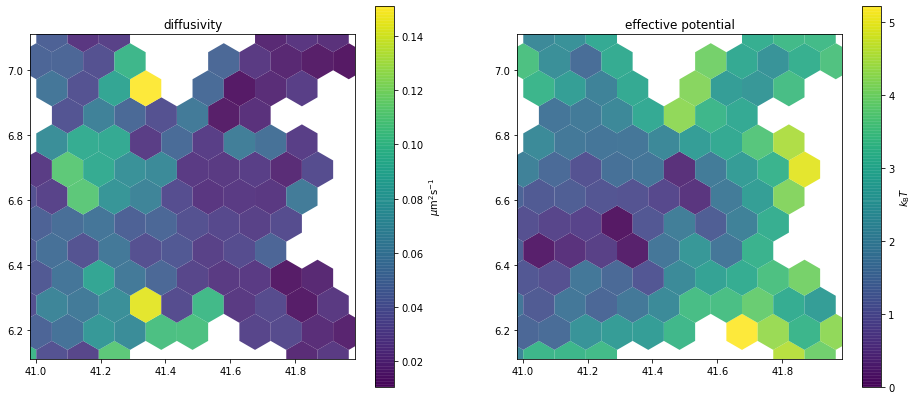

In [59]:
_, ax                             = plt.subplots(1, 2, figsize=(16,7))
a.mapper.mpl.plot(inferred_parameters, feature='diffusivity', sampling=data_sampling, title='diffusivity',         unit='std', axes=ax[0])
a.mapper.mpl.plot(inferred_parameters, feature='potential',   sampling=data_sampling, title='effective potential', unit='std', axes=ax[1])

First, as the data sampling has a direct impact on the appearance of the inferred parameter maps, let us detail again this step:

* first, due to `min_location_count=1`, the bins with less than one data point were excluded from the analysis (and not drawn);
* second, due to `from_nearest_neighbors(10)`, the bins with less than 10 data points were extended to include nearest neighbors of the bin center so that 10 data points were eventually assigned to the bin; note that the resulting bin overlap cannot be directed appreciated on the figures.

Second, the DV model was given two so-called *prior* parameters. These hyperparameters act as regularizing or smoothing parameters. They are trade-off parameters and each parameter weights a penalizing term like -- for example for diffusivity $D$:

$\sum_i\sum_{j \in N_i}\frac{(D_i-D_j)^2}{||\textbf{r}_i-\textbf{r}_j||^2}$ where $N_i$ are the neighbor bins of bin $i$

These penalizing terms can be viewed as improper priors, *i.e.* priors that are not normalized. The task of normalizing these priors is left to the user, if she so wishes.

TRamWAy favors such not-normalized priors because they are more suitable for regularizing several data sets the same way. However, the hyperparameter selection is made a more difficult task and, for now, no reference search procedures are provided. This all depends on a trade-off between outlier removal and the expected scale for the optimal caracterization of the biological processes of interest.

## Custom mappers

The `mapper` attribute of an RWAnalyzer can be supplied with a custom function instead.
Such a function must take a [FiniteElements](https://tramway.readthedocs.io/en/latest/tramway.inference.html#tramway.inference.base.FiniteElements) object that basically operates like a dict of [Translocations](https://tramway.readthedocs.io/en/latest/tramway.inference.html#tramway.inference.base.Translocations) objects (for translocation data).
These latter objects feature data attributes such as `dr` for the assigned translocations/displacements, `dt` for the corresponding time steps (usually all equal to the frame interval) and `n` for the corresponding trajectory indices.

Below is a very basic example that counts the number of translocations assigned to each bin:

In [60]:
import numpy  as np
import pandas as pd

def translocation_count(microdomains):
    index, value = [], []
    for i in microdomains:
        index.append(i)
        value.append(len(microdomains[i].dr))
    return pd.DataFrame({'n': pd.Series(value, index)})

Again, define the processing steps:

In [61]:
from tramway.analyzer import *

a                                 = RWAnalyzer()

a.spt_data.from_ascii_file('data-examples/demo1.txt')
a.spt_data.localization_precision = 0.02

a.tesseller                       = tessellers.Hexagons

a.sampler.from_nearest_neighbors(10)
a.sampler.min_location_count      = 1

In [62]:
a.mapper.from_callable(translocation_count)

...and run them:

In [63]:
# step 1. read the data
translocation_data                = a.spt_data.dataframe
# step 2. sample the data
data_sampling                     = a.sampler.sample(translocation_data)
# step 3. extract the desired local estimates
counts                            = a.mapper.infer(data_sampling)
# step 4. print
n                                 = counts.maps
n

n
0     10
1     61
2     10
3     10
9     10
..   ...
140  238
141   44
146   10
147   16
148   10

[114 rows x 1 columns]

The excluded bins do not appear in the resulting dataframe. Building a dataframe with all the bins represented, and a default value for the excluded bins, should be performed as a post-processing step:

In [64]:
n_full                           = pd.DataFrame(
                                        # 0 as default value
                                        np.zeros(shape=(data_sampling.number_of_cells, 1), dtype=int),
                                        columns=n.columns,
                                        )
n_full.at[n.index]               = n
n_full

n
0    10
1    61
2    10
3    10
4     0
..   ..
145   0
146  10
147  16
148  10
149   0

[150 rows x 1 columns]

## Analyzing trajectories

The binning/sampling does not preserve the trajectories, since the displacements are individualized and assigned to possibly different bins.

As showed in [another notebook](test_single_traj.ipynb), an approach consists of making the full dataframe accessible in the function namespace, and retrieving the trajectory using the indices in the `n` attribute:

In [65]:
import numpy  as np
import pandas as pd

def mean_trajectory_feature(trajectory_data, feature, feature_name='my feature'):
    
    def infer(microdomains):
        index, value           = [], []
        for i in microdomains:

            trajectory_indices = np.unique( microdomains[i].n )

            local_estimates    = []
            for j in trajectory_indices:

                # trajectory_data is accessible from within the function
                trajectory     = trajectory_data[ trajectory_data['n'] == j ]

                # do something with the `trajectory` dataframe
                local_estimate = feature(trajectory)

                if not (local_estimate is None or np.isnan(local_estimate) or np.isinf(local_estimate)):
                    local_estimates.append(local_estimate)

            if local_estimates:
                mean_estimate  = np.mean(local_estimates)

                index.append(i)
                value.append(mean_estimate)

        return pd.DataFrame({feature_name: pd.Series(value, index)})
    
    return infer

In [66]:
from tramway.analyzer import *

a                                 = RWAnalyzer()

a.spt_data.from_ascii_file('data-examples/demo1.txt')
a.spt_data.localization_precision = 0.02

a.tesseller                       = tessellers.Hexagons

a.sampler.from_nearest_neighbors(10)
a.sampler.min_location_count      = 1

In [67]:
# step 1. is performed before defining the mapper function
translocation_data                = a.spt_data.dataframe

These demo data are [translocations and not trajectories](#Locations,-trajectories-and-translocations); convert:

In [68]:
from tramway.core import translocations_to_trajectories

trajectory_data                   = translocations_to_trajectories(translocation_data)

In [69]:
# (too) simple example: let us estimate the mean length of the trajectories that go through the bin
my_function                       = mean_trajectory_feature(trajectory_data, len, 'mean trajectory length')

a.mapper.from_callable(my_function)

In [70]:
# step 2. sample the data
data_sampling                     = a.sampler.sample(trajectory_data)
# step 3. extract the desired local estimates
mean_lengths                      = a.mapper.infer(data_sampling)
# step 4. print
mean_lengths.maps

mean trajectory length
4                  6.000000
11                 3.666667
12                 3.000000
17                 6.272727
18                 7.647059
..                      ...
153                2.333333
154               10.000000
155                9.200000
159                6.400000
160               10.666667

[87 rows x 1 columns]

## *Embarrassingly parallel* mapper functions

On platforms other than Windows, the low level mechanics of `infer` readily features some degree of parallelism for such *embarrassingly parallel* computations. If the core calculation of the function could be applied to each microdomain independently, instead of iterating the microdomains, `mapper` can be set to call the function for each bin, but the function should still iterate the bins. `infer` will actually build as many single-element `FiniteElements` objects as valid bins, and combine the output single-row or empty dataframes:

In [71]:
import numpy  as np
import pandas as pd

# here is (again) our most embarrassing function:
def translocation_count(microdomains):
    index, value = [], []
    for i in microdomains:
        index.append(i)
        value.append(len(microdomains[i]))
    return pd.DataFrame({'n': pd.Series(value, index)})

In [72]:
from tramway.analyzer import *

a                                 = RWAnalyzer()

a.spt_data.from_ascii_file('data-examples/demo1.txt')
a.spt_data.localization_precision = 0.02

a.tesseller                       = tessellers.Hexagons

a.sampler.from_nearest_neighbors(10)
a.sampler.min_location_count      = 1

In [73]:
a.mapper.from_callable(translocation_count)
a.mapper.cell_sampling            = 'individual'  # <- here is the main difference!

In [74]:
# step 1. read the data
translocation_data                = a.spt_data.dataframe
# step 2. sample the data
data_sampling                     = a.sampler.sample(translocation_data)
# step 3. extract the desired local estimates
parallel_counts                   = a.mapper.infer(data_sampling) # on Windows, this hangs and can be stopped restarting the notebook

# compare
parallel_n                        = parallel_counts.maps
assert np.all( parallel_n.index  == n.index  )
assert np.all( parallel_n.values == n.values )

Of course, parallelizing the example function is counterproductive due to the overhead. Parallizing is desirable for computer-intensive atomic computations only.

Another limitation of this mechanics is that the spawned parallel processes run on the local host and cannot be dispatched as jobs to different nodes of a computer cluster, for example.

The RWAnalyzer introduces an additional layer for defining and running a pipeline either locally or remotely. However, such pipelines also suffer from some limitations and require a [dedicated notebook](RWAnalyzer%20standard%20pipeline.ipynb).